# Advanced Lane Finding

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

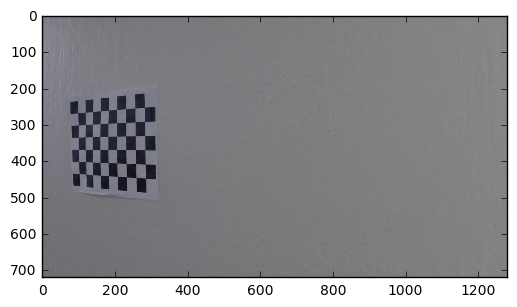

In [2]:
list_images = glob.glob('camera_cal/*')
img_chess = mpimg.imread(list_images[12])
plt.imshow(img_chess)

In [3]:
obj_points = []
img_points = []

nx = 9
ny = 6
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for im_path in list_images:
    img = mpimg.imread(im_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
        img_points.append(corners)
        obj_points.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)


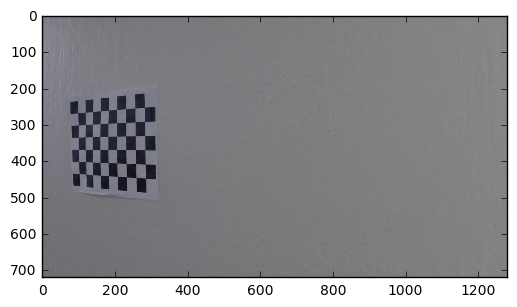

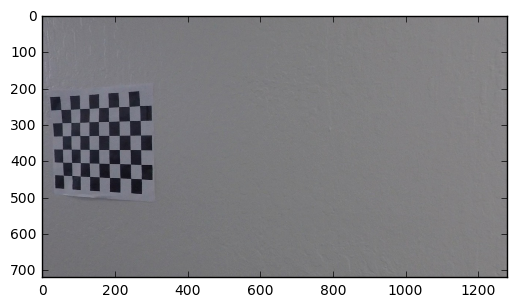

In [4]:
undist = cv2.undistort(img_chess, mtx, dist, None, mtx)
plt.figure()
plt.imshow(img_chess)
plt.figure()
plt.imshow(undist)

## Binarization of images using gradients and color transformation

In [45]:
# functions to get a good mask for an image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))

    binary_output = scaled_sobel > thresh[0]
    binary_output = binary_output*(scaled_sobel < thresh[1])
    return binary_output


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
    binary_output = scaled_sobel > mag_thresh[0]
    binary_output = binary_output*(scaled_sobel < mag_thresh[1])
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    angle_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = angle_sobel > thresh[0]
    binary_output = binary_output*(angle_sobel < thresh[1])
    return binary_output


def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,2]
    binary_output = np.zeros_like(s_ch)
    binary_output[(s_ch > thresh[0]) & (s_ch <= thresh[1])] = 1
    return binary_output

In [46]:
road_list_images = glob.glob('test_images/*')
img_road = mpimg.imread(road_list_images[5])

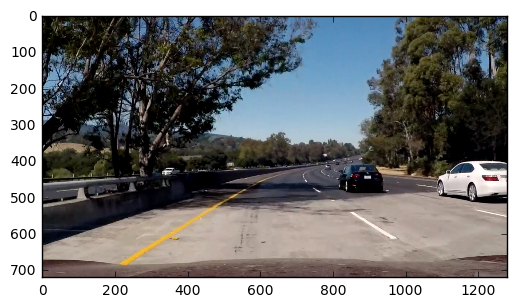

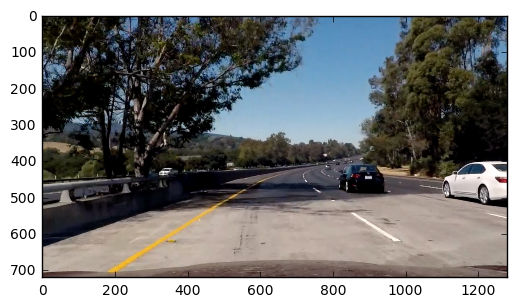

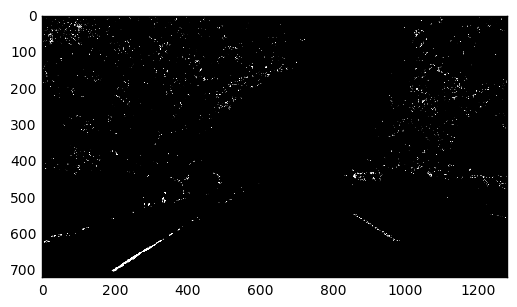

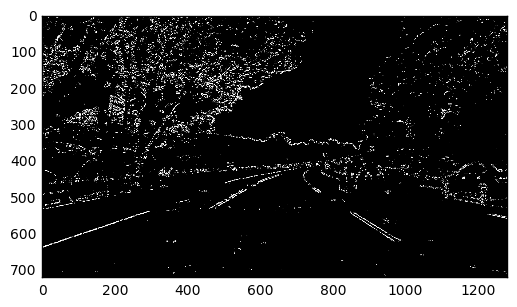

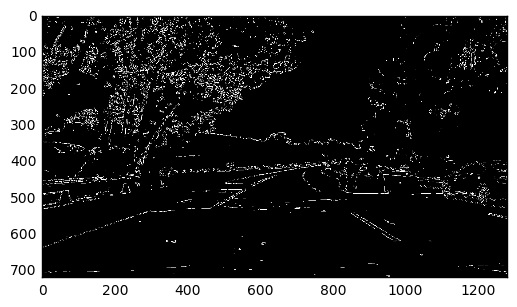

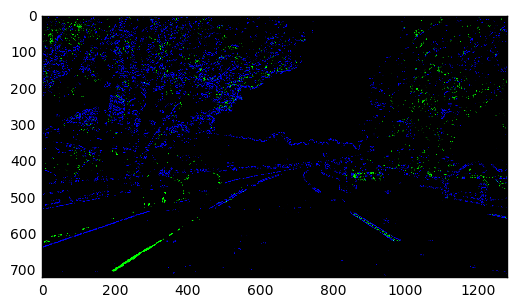

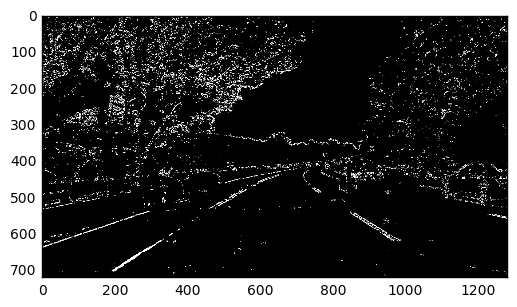

In [52]:
# Apply each of the thresholding functions
ksize=3
img_road_undist = cv2.undistort(img_road, mtx, dist, None, mtx)
gradx = abs_sobel_thresh(img_road_undist, orient='x', sobel_kernel=ksize, thresh=(10, 100))
grady = abs_sobel_thresh(img_road_undist, orient='y', sobel_kernel=ksize, thresh=(30, 120))
mag_binary = mag_thresh(img_road_undist, sobel_kernel=ksize, mag_thresh=(50, 80))
dir_binary = dir_threshold(img_road_undist, sobel_kernel=ksize, thresh=(0.05, 0.8))
s_binary = hls_select(img_road_undist, thresh=(210,250))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | (s_binary == 1)] = 1
combined_gray = np.uint8(255*combined)
combined_color = cv2.cvtColor(combined_gray, cv2.COLOR_GRAY2RGB)


gc = np.uint8(np.zeros_like(s_binary))
bc = np.uint8(np.zeros_like(s_binary))
bc[((gradx == 1) & (grady == 1))] = 1
gc[s_binary==1] = 1

color_binary = np.dstack((np.zeros_like(s_binary), 255*gc, 255*bc))


plt.figure()
plt.imshow(img_road)
plt.figure()
plt.imshow(img_road_undist)
plt.figure()
plt.imshow(gc,cmap='gray')
plt.figure()
plt.imshow(bc,cmap='gray')
plt.figure()
plt.imshow(mag_binary,cmap='gray')
plt.figure()
plt.imshow(color_binary)
plt.figure()
plt.imshow(combined,cmap='gray')

## Perspective transform

* select four points (vertices) to make a perspective transform and get the "bird-eye view"

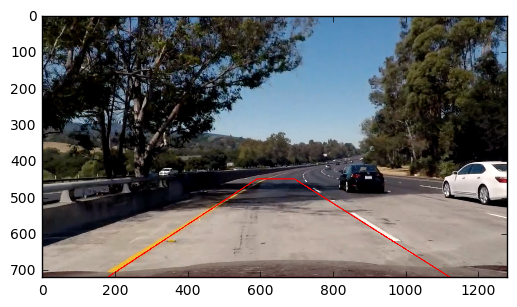

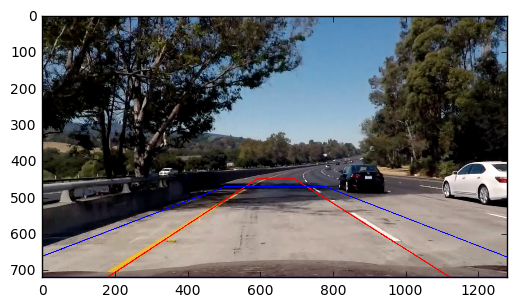

In [53]:
# set and draw trapezoidal section of the road
vertices = np.array([[(180, img_road_undist.shape[0]),
                      (590, 450),
                      (693, 450),
                      (1120, img_road_undist.shape[0])]], dtype=np.int32)
img_example_section = img_road_undist.copy()
section_image_red = cv2.drawContours(img_example_section, vertices, 0, (255,0,0), 2)
section_image_red_copy = section_image_red.copy()

plt.figure()
plt.imshow(section_image_red)

# source points for transformation
blue_srcp = srcp = np.array([[(505, 470),
                              (775, 470),
                              (1420, img_road_undist.shape[0]),
                              (-150, img_road_undist.shape[0])]], dtype=np.int32)

# draw source points
section_image_red_blue = cv2.drawContours(section_image_red_copy, blue_srcp, 0, (0,0,255), 2)
plt.figure()
plt.imshow(section_image_red_blue)

* perform perspective transformation using opencv

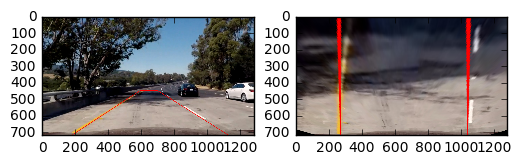

In [54]:
img_size=(img_road_undist.shape[1], img_road_undist.shape[0])
dstp = np.float32([[0, 0],
                    [img_size[0], 0],
                    [img_size[0], img_size[1]],
                    [0, img_size[1]]])
M = cv2.getPerspectiveTransform(np.float32(blue_srcp), dstp)

warped = cv2.warpPerspective(section_image_red, M, img_size)
plt.figure()
plt.subplot(121)
plt.imshow(section_image_red)
plt.subplot(122)
plt.imshow(warped)

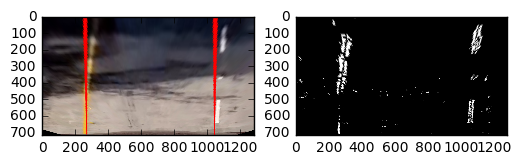

In [55]:
warped_binarized = cv2.warpPerspective(combined_gray, M, img_size)
plt.figure()
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(warped_binarized,cmap='gray')

## Finding Lanes

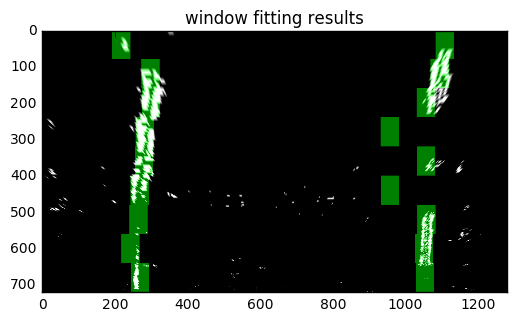

In [56]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

warped = warped_binarized.copy()
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # if no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure()
plt.imshow(output)
plt.title('window fitting results')
plt.show()